<a href="https://colab.research.google.com/github/mejia080902-bit/pymc-examples/blob/main/oyamel_monte_carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimación del número de árboles de oyamel con Monte Carlo

Este cuaderno implementa el experimento de simulación descrito en el proyecto:
estimación del número total de árboles de oyamel (*Abies religiosa*) en un polígono de estudio dentro de la Reserva de la Biosfera Mariposa Monarca, usando parcelas circulares y un modelo de Poisson homogéneo.

Iremos paso a paso:
1. Definición de parámetros del modelo.
2. Implementación de la simulación de Monte Carlo.
3. Cálculo de sesgo, varianza y ECM del estimador.
4. Experimentos variando el número de parcelas y su tamaño.
5. Espacios para escribir observaciones y conclusiones.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Opcional: estilo b
plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['axes.grid'] = True


## 1. Parámetros base del modelo

En esta sección definimos los parámetros del **bosque "verdadero"** y del esquema de muestreo. Puedes modificar estos valores para probar diferentes escenarios.

- `lambda_0`: intensidad verdadera (árboles por unidad de área).
- `A_T`: área total del polígono de estudio.
- `r`: radio de las parcelas circulares.
- `m`: número de parcelas.
- `K`: número de réplicas en la simulación de Monte Carlo.


In [2]:
# -----------------------------
# Parámetros del bosque "verdadero"
# -----------------------------

lambda_0 = 300.0   # árboles por unidad de área (ajusta según el escenario)
A_T      = 100.0   # área total del polígono de estudio

# -----------------------------
# Parámetros de muestreo
# -----------------------------

r = 0.02          # radio de las parcelas circulares
m = 20            # número de parcelas
K = 10_000        # número de réplicas de Monte Carlo

# Cálculos derivados
A_p = np.pi * r**2
N_T_true = lambda_0 * A_T

print(f"Área de cada parcela A_p = {A_p:.6f}")
print(f"Número total verdadero N_T = {N_T_true:.2f}")

Área de cada parcela A_p = 0.001257
Número total verdadero N_T = 30000.00


## 2. Funciones para la simulación de Monte Carlo

Definimos una función que realiza la simulación de Monte Carlo dada una configuración de parámetros, y otra función auxiliar para resumir los resultados.


In [3]:
def monte_carlo_estimation(lambda_0, A_T, r, m, K, seed=None):
    """Ejecuta la simulación de Monte Carlo para el estimador N_T.

    Devuelve:
        N_T_hat : arreglo de tamaño K con las K estimaciones del número total de árboles.
        lambda_hat : arreglo de tamaño K con las K estimaciones de la intensidad.
    """
    rng = np.random.default_rng(seed)
    A_p = np.pi * r**2
    # Matriz de conteos: K réplicas x m parcelas
    X = rng.poisson(lam=lambda_0 * A_p, size=(K, m))
    S = X.sum(axis=1)  # suma de conteos por réplica
    lambda_hat = S / (m * A_p)
    N_T_hat = lambda_hat * A_T
    return N_T_hat, lambda_hat

def summarize_estimates(N_T_hat, N_T_true):
    """Calcula media, sesgo, varianza y ECM de las estimaciones de N_T."""
    mean_hat = N_T_hat.mean()
    bias = mean_hat - N_T_true
    var  = N_T_hat.var(ddof=1)
    mse  = ((N_T_hat - N_T_true)**2).mean()
    return {
        'media': mean_hat,
        'sesgo': bias,
        'varianza': var,
        'ECM': mse,
    }

## 3. Corrida base: un escenario de referencia

Ejecutamos ahora la simulación con los parámetros definidos arriba y observamos las métricas principales del estimador $\hat{N}_T$.


In [4]:
# Ejecutar simulación base
N_T_hat_base, lambda_hat_base = monte_carlo_estimation(
    lambda_0=lambda_0,
    A_T=A_T,
    r=r,
    m=m,
    K=K,
    seed=42,
)

resumen_base = summarize_estimates(N_T_hat_base, N_T_true)
print("Resultados de la corrida base:")
for k, v in resumen_base.items():
    print(f"  {k:9s}: {v:.4f}")

Resultados de la corrida base:
  media    : 30069.1434
  sesgo    : 69.1434
  varianza : 119547650.1238
  ECM      : 119540476.1683


### 3.1. Distribución aproximada de $\hat{N}_T$

Graficamos un histograma de las estimaciones de $N_T$ para ver su comportamiento aproximado y lo comparamos con el valor verdadero.


<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-3963690590.py:6: SyntaxWarning: invalid escape sequence '\h'
  plt.title('Distribución Monte Carlo de $\hat{N}_T$ (corrida base)')


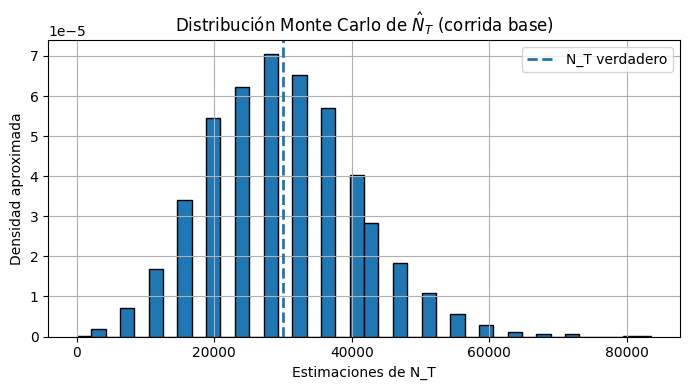

In [5]:
plt.figure()
plt.hist(N_T_hat_base, bins=40, density=True, edgecolor='black')
plt.axvline(N_T_true, linestyle='--', linewidth=2, label='N_T verdadero')
plt.xlabel('Estimaciones de N_T')
plt.ylabel('Densidad aproximada')
plt.title('Distribución Monte Carlo de $\hat{N}_T$ (corrida base)')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Experimentos: efecto del número de parcelas y su tamaño

En esta sección podemos explorar cómo cambian el sesgo, la varianza y el ECM del estimador al modificar:

- El número de parcelas $m$.
- El radio $r$ (y por lo tanto el área $A_p$).

La idea es que uses estas pruebas como base para escribir tus conclusiones en el reporte.


In [6]:
def experimento_variando_m(m_vals, lambda_0, A_T, r, K, seed_base=123):
    """Corre varios escenarios cambiando m y devuelve un diccionario
    con las métricas de cada caso.
    """
    resultados = []
    for j, m_val in enumerate(m_vals):
        # Cambiamos la semilla para cada m pero de forma reproducible
        seed = seed_base + j
        N_T_hat, _ = monte_carlo_estimation(lambda_0, A_T, r, m_val, K, seed=seed)
        resumen = summarize_estimates(N_T_hat, N_T_true)
        resumen['m'] = m_val
        resultados.append(resumen)
    return resultados

m_vals = [5, 10, 20, 40, 80]
resultados_m = experimento_variando_m(m_vals, lambda_0, A_T, r, K=3000)

print("Resultados variando m (K = 3000 réplicas):")
for res in resultados_m:
    print(f"m = {res['m']:3d}  -> media: {res['media']:.2f}, sesgo: {res['sesgo']:.2f}, "
          f"Var: {res['varianza']:.2f}, ECM: {res['ECM']:.2f}")

Resultados variando m (K = 3000 réplicas):
m =   5  -> media: 29326.95, sesgo: -673.05, Var: 478711228.98, ECM: 479004653.73
m =  10  -> media: 29942.35, sesgo: -57.65, Var: 230688525.89, ECM: 230614953.24
m =  20  -> media: 30311.06, sesgo: 311.06, Var: 121352662.91, ECM: 121408969.67
m =  40  -> media: 29946.99, sesgo: -53.01, Var: 58179563.98, ECM: 58162980.64
m =  80  -> media: 29993.08, sesgo: -6.92, Var: 30047321.73, ECM: 30037353.83


Puedes ejecutar la celda anterior varias veces cambiando `m_vals` para ver cómo influyen las muestras en la precisión del estimador. También puedes definir una función similar para variar el radio $r$.


## 5. Espacio para notas y conclusiones

Usa este espacio (o crea más celdas Markdown) para anotar tus observaciones. Algunas guías para tus conclusiones:

- ¿El estimador $\hat{N}_T$ parece insesgado en los escenarios probados?
- ¿Cómo cambia la varianza (y el ECM) al incrementar el número de parcelas $m$?
- ¿Qué combinación de parámetros ($m$, $r$) te parece razonable en términos de esfuerzo de campo vs. precisión?
- ¿Cómo relacionarías estos resultados con el caso real de los bosques de oyamel en la zona monarca?

Redacta aquí tus ideas principales para luego usarlas en la sección de conclusiones del reporte escrito.